# Heart Failure Prediction - Model Comparison and Evaluation

This notebook aims to predict heart failure using multiple classification models and evaluate them thoroughly using robust validation techniques.

### Objectives:

- Train and evaluate Decision Tree, Random Forest, SVM, and KNN classifiers
- Apply cross-validation and report average F1 scores
- Generate classification reports and confusion matrices
- Plot ROC curves and calculate AUC
- Tune hyperparameters using `RandomizedSearchCV`
- Compare results and conclude with performance insights

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heart-failure-prediction


In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

## Dataset Summary

The dataset contains patient health metrics and a binary target indicating the presence (1) or absence (0) of heart failure.

### Features:
- Age
- Sex
- ChestPainType
- RestingBP
- Cholestrol
- FastingBS
- RestingECG
- MaxHR
- ExerciseAngina
- Oldpeak
- ST_Slope

### Target:
- `HeartDisease`: 
  - 1 → Diagnosed
  - 0 → Not diagnosed


In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
df.shape

(918, 12)

In [8]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Data Preprocessing

In [9]:
x = df.iloc[:,:-1]
x

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


In [10]:
y = df.iloc[:,-1]
y

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

## Label Encoding

Label Encoding is a technique used to convert categorical data (like names or labels) into numerical format, which is required for most machine learning algorithms.

It works by assigning each unique category in a feature or label column a unique integer value. The encoder scans through all the unique values, builds an internal mapping (like a dictionary), and then replaces the original categorical values with their corresponding numeric codes.

This process is especially useful for encoding **target labels** in classification problems, where the output variable needs to be in numeric form for model training.

### How it Works:
1. It identifies all unique values in the data column.
2. Each unique value is mapped to a distinct integer, starting from 0.
3. The original column is transformed by replacing each value with its corresponding integer.

### Note:
- Label encoding only **translates categories into numbers** — it does **not imply any ranking or order** by default.
- However, some models (like linear regression or distance-based algorithms) may mistakenly **interpret the numerical values as having an order**, which can introduce bias if the original data is nominal.
- Therefore, Label Encoding is best used when:
  - The encoded column is the **target variable**, or
  - The categorical data has a **natural order** (ordinal).

In cases where the categorical variable is purely nominal and order does not matter, it is better to use **One-Hot Encoding**, which avoids introducing any false ordinal relationships.


In [13]:
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder()
x['Sex'] =labels.fit_transform(x["Sex"])
x['ChestPainType'] =labels.fit_transform(x["ChestPainType"])
x['RestingECG'] =labels.fit_transform(x["RestingECG"])
x['ExerciseAngina'] =labels.fit_transform(x["ExerciseAngina"])
x['ST_Slope'] =labels.fit_transform(x["ST_Slope"])

## Feature Scaling

Some models like **SVM** and **KNN** are **distance-based** — their performance is highly sensitive to the **scale of input features**.

We apply **StandardScaler**:
$$
X_{scaled} = \frac{X - \mu}{\sigma}
$$

- $\mu$ = mean of the feature
- $\sigma$ = standard deviation

This transformation ensures that each feature contributes equally during model training.

In [17]:
from sklearn.preprocessing import StandardScaler


scaler=StandardScaler()
x=scaler.fit_transform(x)

### Splitting into training and testing data (80 / 20)

In [20]:
from sklearn.model_selection import train_test_split

x_train ,x_test ,y_train ,y_test =train_test_split(x,y,test_size=0.2,random_state=42)

## Evaluation Metrics

We evaluate each model based on:

- **Accuracy**: Proportion of total correct predictions  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision**: Out of all predicted positives, how many are actually positive?  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall** (Sensitivity): Out of all actual positives, how many were correctly predicted?  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1 Score**: Harmonic mean of precision and recall  
  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **ROC-AUC**: Measures the area under the ROC curve, representing model separability.  
  - Closer to 1 → Better model


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, roc_auc_score

In [35]:
dtree = DecisionTreeClassifier()

dtree.fit(x_train, y_train)

DecisionTreeClassifier()

In [36]:
dtree_y_pred = dtree.predict(x_test)

print("F1 score: ", f1_score(y_test, dtree_y_pred))
print("Accuracy score: ", accuracy_score(y_test, dtree_y_pred))
print("ROC-AUC score: ", roc_auc_score(y_test, dtree_y_pred, average = 'weighted'))
print(classification_report(y_test, dtree_y_pred))

F1 score:  0.8159203980099503
Accuracy score:  0.7989130434782609
ROC-AUC score:  0.8052554921713799
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        77
           1       0.87      0.77      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.80       184



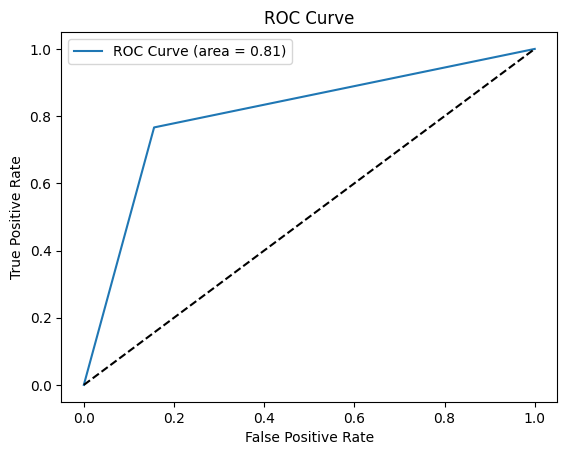

In [99]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, dtree.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [102]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best', 'random']
}

dtree_rcv = RandomizedSearchCV(estimator = dtree,param_distributions = param_grid, scoring = 'f1', n_jobs = -1)

dtree_rcv.fit(x_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   scoring='f1')

In [40]:
print("Best parameters:", dtree_rcv.best_params_)
print("Best F1 Score (CV):", dtree_rcv.best_score_)

Best parameters: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
Best F1 Score (CV): 0.8454638900336977


In [105]:
param_grid_refined = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [8, 10, 12],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dtree_rcv = RandomizedSearchCV(estimator = dtree,param_distributions = param_grid_refined, scoring = 'f1', n_jobs = -1)

dtree_rcv.fit(x_train, y_train)

print("Best parameters:", dtree_rcv.best_params_)
print("Best F1 Score (CV):", dtree_rcv.best_score_)

Best parameters: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 12, 'criterion': 'entropy'}
Best F1 Score (CV): 0.8496902368859596


In [106]:
y_pred_hp_tuned_dtree = dtree_rcv.predict(x_test)

print("F1 score: ", f1_score(y_test, dtree_y_pred))
print("Accuracy score: ", accuracy_score(y_test, dtree_y_pred))
print("ROC-AUC score: ", roc_auc_score(y_test, dtree_y_pred))
print(classification_report(y_test, dtree_y_pred))

F1 score:  0.8159203980099503
Accuracy score:  0.7989130434782609
ROC-AUC score:  0.8052554921713799
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        77
           1       0.87      0.77      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.80       184



## K-Fold Cross-Validation

Instead of a single train-test split, we use **Stratified K-Fold Cross-Validation**:

- Data is split into K equal-sized "folds"
- Each fold acts as the test set once; the model trains on the remaining K-1 folds
- **Stratified** ensures class distribution is preserved across all folds

This gives a more reliable performance estimate, especially on smaller datasets.


In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate base model
dtree_scores = cross_val_score(dtree, x, y, cv=skf, scoring='f1')
print("Base Decision Tree - F1 Scores:", dtree_scores)
print(f"Mean: {dtree_scores.mean()}, Std: {dtree_scores.std()}")

# Evaluate hyperparameter tuned model
dtree_rcv_scores = cross_val_score(dtree_rcv, x, y, cv=skf, scoring='f1')
print("Tuned Decision Tree - F1 Scores:", dtree_rcv_scores)
print(f"Mean: {dtree_rcv_scores.mean()}, Std: {dtree_rcv_scores.std()}")

Base Decision Tree - F1 Scores: [0.82105263 0.78306878 0.77832512 0.76616915 0.76555024]
Mean: 0.7828331862527491, Std: 0.020285434975600657
Tuned Decision Tree - F1 Scores: [0.89756098 0.8125     0.79411765 0.83902439 0.80193237]
Mean: 0.8290270760124481, Std: 0.03747739960456074


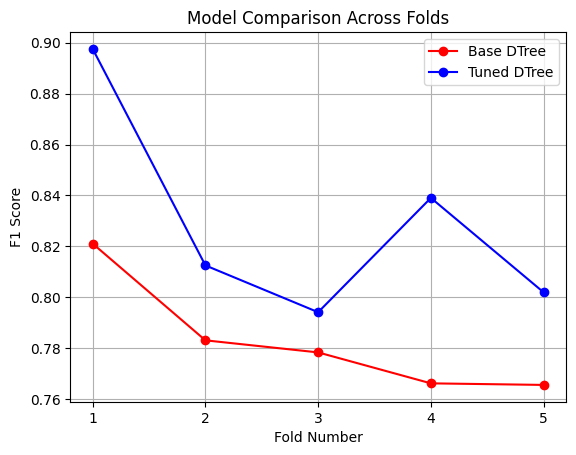

In [76]:
import matplotlib.pyplot as plt
import numpy as np

folds = range(1, len(dtree_scores) + 1)

plt.plot(folds, dtree_scores, marker='o', label='Base DTree', color='red')
plt.plot(folds, dtree_rcv_scores, marker='o', label='Tuned DTree', color='blue')

plt.xticks(folds)
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')
plt.title('Model Comparison Across Folds')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [69]:
y_pred_forest = rf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("Weighted F1 score: ", f1_score(y_test, y_pred_forest))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

Accuracy: 0.8804347826086957
Weighted F1 score:  0.8962264150943396
ROC AUC Score:  0.8789901687097949
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## Hyperparameter Tuning with RandomizedSearchCV

Hyperparameters significantly impact model performance. We use:

- `RandomizedSearchCV`:
  - Randomly samples a fixed number of combinations from a parameter grid
  - Faster than GridSearchCV with large grids

### Example for Random Forest:
- `n_estimators`: Number of trees
- `max_depth`: Max tree depth
- `min_samples_split`: Min samples to split a node
- `max_features`: Max features per split

We use 5-fold CV within `RandomizedSearchCV` to find the best parameters.


In [72]:
param_grid = {
    'n_estimators': [1000,1200,1500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2,5,7],
    'min_samples_leaf': [1,2,5],
    'max_features': ['sqrt', 'log2',None]
}

rf_rcv = RandomizedSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

rf_rcv.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=1000,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [1000, 1200, 1500]},
                   scoring='accuracy')

In [74]:
print("Best params:", rf_rcv.best_params_)
print("Best score:", rf_rcv.best_score_)

Best params: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best score: 0.8678408349641227


In [73]:
y_pred_rf_rcv = rf_rcv.predict(x_test)

print("Weighted F1 Score: ", f1_score(y_test, y_pred_rf_rcv))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_rf_rcv))
print("ROC-AUC Score: ", roc_auc_score(y_test, y_pred_rf_rcv))
print(classification_report(y_test, y_pred_rf_rcv))

Weighted F1 Score:  0.9056603773584906
Accuracy Score:  0.8913043478260869
ROC-AUC Score:  0.890156572399563
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.91      0.90      0.91       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate base model
rf_scores = cross_val_score(rf, x, y, cv=skf, scoring='f1')
print("Base Random Forest - F1 Scores:", rf_scores)
print(f"Mean: {rf_scores.mean()}, Std: {rf_scores.std()}")

# Evaluate hyperparameter tuned model
rf_rcv_scores = cross_val_score(rf_rcv, x, y, cv=skf, scoring='f1')
print("Tuned Random Forest - F1 Scores:", rf_rcv_scores)
print(f"Mean: {rf_rcv_scores.mean()}, Std: {rf_rcv_scores.std()}")

Base Random Forest - F1 Scores: [0.90547264 0.88118812 0.85714286 0.90384615 0.86255924]
Mean: 0.8820418016645947, Std: 0.020123072157052016
Tuned Random Forest - F1 Scores: [0.90640394 0.87562189 0.86384977 0.90909091 0.89201878]
Mean: 0.8893970570251624, Std: 0.01747211872611351


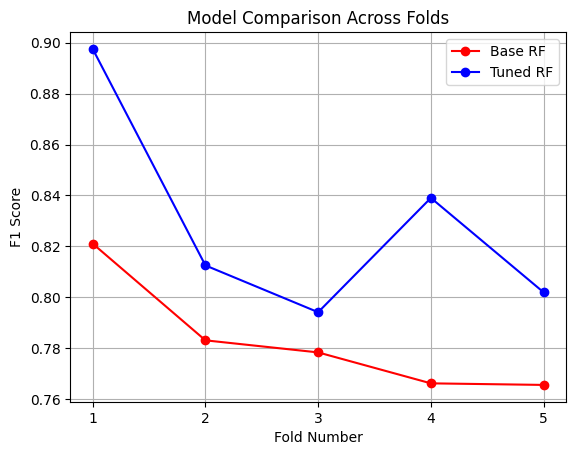

In [77]:
folds = range(1, len(rf_scores) + 1)

plt.plot(folds, dtree_scores, marker='o', label='Base RF', color='red')
plt.plot(folds, dtree_rcv_scores, marker='o', label='Tuned RF', color='blue')

plt.xticks(folds)
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')
plt.title('Model Comparison Across Folds')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=42)
svc.fit(x_train, y_train)

SVC(probability=True, random_state=42)

In [80]:
y_pred_svc = svc.predict(x_test)

print("SVC - Accuracy:", accuracy_score(y_test, y_pred_svc))
print("SVC - F1 score:", f1_score(y_test, y_pred_svc))
print("SVC - ROC AUC Score:", roc_auc_score(y_test, svc.predict_proba(x_test)[:, 1]))
print(classification_report(y_test, y_pred_svc))

SVC - Accuracy: 0.8641304347826086
SVC - F1 score: 0.881516587677725
SVC - ROC AUC Score: 0.948416069911397
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [81]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

svc_rcv = RandomizedSearchCV(SVC(probability=True, random_state=42), param_grid_svc, 
                             scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

svc_rcv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'degree': [2, 3, 4],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='accuracy')

In [82]:
print("Best params (SVC):", svc_rcv.best_params_)
print("Best accuracy (CV):", svc_rcv.best_score_)

Best params (SVC): {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 1}
Best accuracy (CV): 0.866470971950424


In [84]:
y_pred_svc_rcv = svc_rcv.predict(x_test)

print("Tuned SVC - F1 Score:", f1_score(y_test, y_pred_svc_rcv))
print("Tuned SVC - Accuracy Score:", accuracy_score(y_test, y_pred_svc_rcv))
print("Tuned SVC - ROC-AUC Score:", roc_auc_score(y_test, svc_rcv.predict_proba(x_test)[:, 1]))
print(classification_report(y_test, y_pred_svc_rcv))

Tuned SVC - F1 Score: 0.881516587677725
Tuned SVC - Accuracy Score: 0.8641304347826086
Tuned SVC - ROC-AUC Score: 0.9482946959582473
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svc_scores = cross_val_score(svc, x, y, cv=skf, scoring='f1_weighted')
svc_rcv_scores = cross_val_score(svc_rcv, x, y, cv=skf, scoring='f1_weighted')

print("Base SVC - F1 Scores:", svc_scores)
print(f"Mean: {svc_scores.mean()}, Std: {svc_scores.std()}")

print("Tuned SVC - F1 Scores:", svc_rcv_scores)
print(f"Mean: {svc_rcv_scores.mean()}, Std: {svc_rcv_scores.std()}")

Base SVC - F1 Scores: [0.88563327 0.84263077 0.82450382 0.89021156 0.86768752]
Mean: 0.8621333870899933, Std: 0.025170670104386318
Tuned SVC - F1 Scores: [0.8909908  0.84263077 0.82450382 0.89021156 0.84382201]
Mean: 0.8584317899450633, Std: 0.02714504820196078


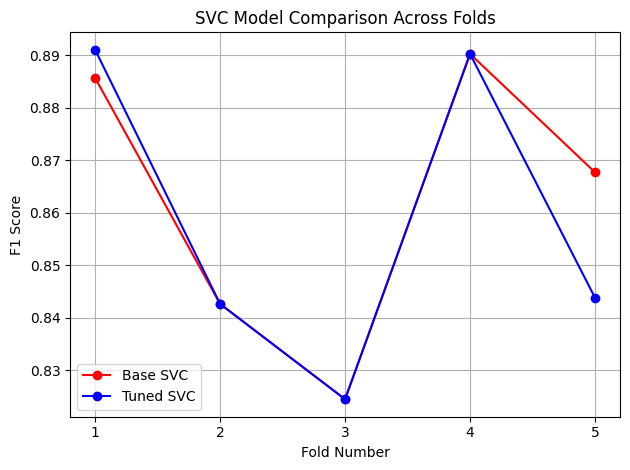

In [87]:
folds = range(1, len(svc_scores) + 1)

plt.plot(folds, svc_scores, marker='o', label='Base SVC', color='red')
plt.plot(folds, svc_rcv_scores, marker='o', label='Tuned SVC', color='blue')

plt.xticks(folds)
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')
plt.title('SVC Model Comparison Across Folds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [91]:
y_pred_knn = knn.predict(x_test)

print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN - F1 score:", f1_score(y_test, y_pred_knn))
print("KNN - ROC AUC Score:", roc_auc_score(y_test, knn.predict_proba(x_test)[:, 1]))
print(classification_report(y_test, y_pred_knn))

KNN - Accuracy: 0.8478260869565217
KNN - F1 score: 0.8627450980392157
KNN - ROC AUC Score: 0.9209248695230003
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        77
           1       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [93]:
param_grid_knn = {
    'n_neighbors': list(range(3, 33, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # p=1 is Manhattan, p=2 is Euclidean
}

knn_rcv = RandomizedSearchCV(knn, param_distributions=param_grid_knn, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

knn_rcv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        17, 19, 21, 23, 25, 27,
                                                        29, 31],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy')

In [ ]:
print("Best params (KNN):", knn_rcv.best_params_)
print("Best accuracy (CV):", knn_rcv.best_score_)

In [94]:
y_pred_knn_rcv = knn_rcv.predict(x_test)

print("Tuned KNN - F1 Score:", f1_score(y_test, y_pred_knn_rcv))
print("Tuned KNN - Accuracy Score:", accuracy_score(y_test, y_pred_knn_rcv))
print("Tuned KNN - ROC-AUC Score:", roc_auc_score(y_test, knn_rcv.predict_proba(x_test)[:, 1]))
print(classification_report(y_test, y_pred_knn_rcv))

Tuned KNN - F1 Score: 0.8952380952380954
Tuned KNN - Accuracy Score: 0.8804347826086957
Tuned KNN - ROC-AUC Score: 0.9405874499332443
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        77
           1       0.91      0.88      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In [95]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_scores = cross_val_score(knn, x, y, cv=skf, scoring='f1')
knn_rcv_scores = cross_val_score(knn_rcv, x, y, cv=skf, scoring='f1')

print("Base KNN - F1 Scores:", knn_scores)
print(f"Mean: {knn_scores.mean()}, Std: {knn_scores.std()}")

print("Tuned KNN - F1 Scores:", knn_rcv_scores)
print(f"Mean: {knn_rcv_scores.mean():.4f}, Std: {knn_rcv_scores.std():.4f}")

Base KNN - F1 Scores: [0.87755102 0.83505155 0.82352941 0.90196078 0.88679245]
Mean: 0.8649770431417071, Std: 0.03038175642634187
Tuned KNN - F1 Scores: [0.9        0.86153846 0.85024155 0.90731707 0.88571429]
Mean: 0.8810, Std: 0.0219


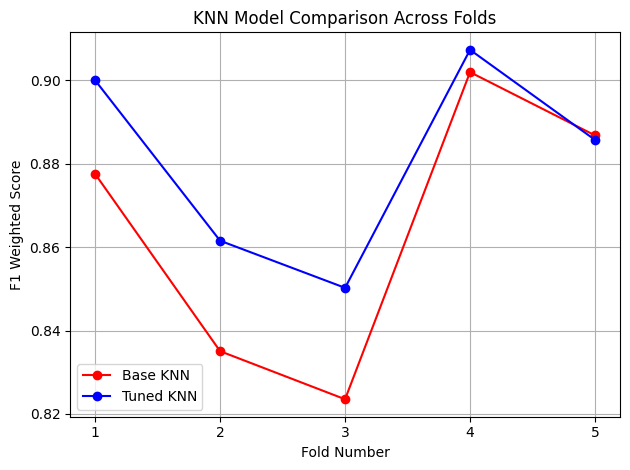

In [96]:
folds = range(1, len(knn_scores) + 1)

plt.plot(folds, knn_scores, marker='o', label='Base KNN', color='red')
plt.plot(folds, knn_rcv_scores, marker='o', label='Tuned KNN', color='blue')

plt.xticks(folds)
plt.xlabel('Fold Number')
plt.ylabel('F1 Weighted Score')
plt.title('KNN Model Comparison Across Folds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Confusion Matrix & ROC Curve

### Confusion Matrix:
Shows the breakdown of actual vs predicted values.

|                | Predicted Positive | Predicted Negative |
|----------------|--------------------|--------------------|
| Actual Positive| True Positive (TP) | False Negative (FN)|
| Actual Negative| False Positive (FP)| True Negative (TN) |

### ROC Curve:
- Plots **True Positive Rate (Recall)** vs **False Positive Rate**
- **AUC (Area Under Curve)** quantifies the overall ability to distinguish classes:
  - 1.0 = perfect
  - 0.5 = random

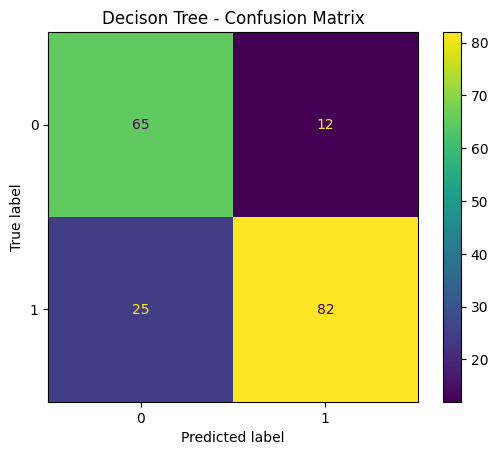

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(dtree, x_test, y_test)
plt.title("Decison Tree - Confusion Matrix")
plt.grid(False)
plt.show()

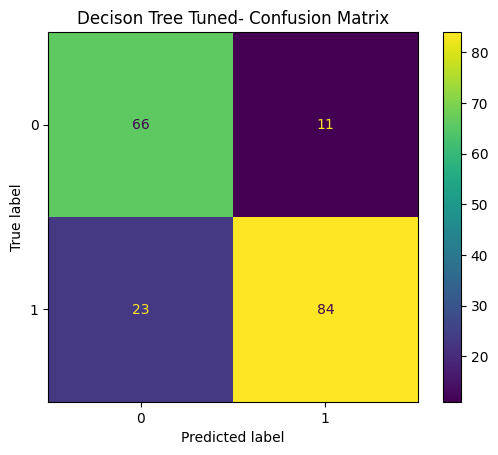

In [132]:
ConfusionMatrixDisplay.from_estimator(dtree_rcv, x_test, y_test)
plt.title("Decison Tree Tuned- Confusion Matrix")
plt.grid(False)
plt.show()

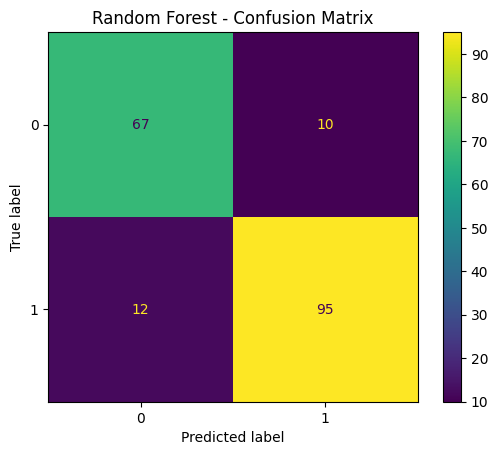

In [111]:
ConfusionMatrixDisplay.from_estimator(rf, x_test, y_test)
plt.title("Random Forest - Confusion Matrix")
plt.grid(False)
plt.show()

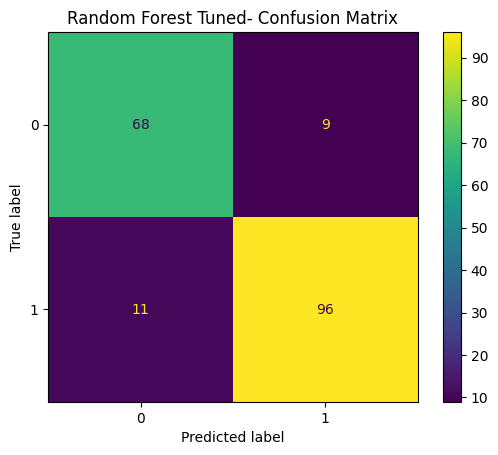

In [110]:
ConfusionMatrixDisplay.from_estimator(rf_rcv, x_test, y_test)
plt.title("Random Forest Tuned- Confusion Matrix")
plt.grid(False)
plt.show()

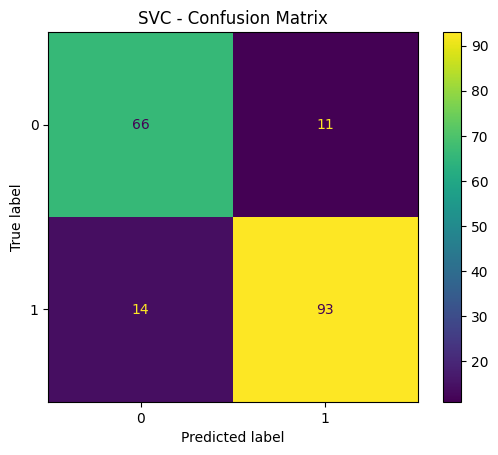

In [114]:
ConfusionMatrixDisplay.from_estimator(svc, x_test, y_test)
plt.title("SVC - Confusion Matrix")
plt.grid(False)
plt.show()

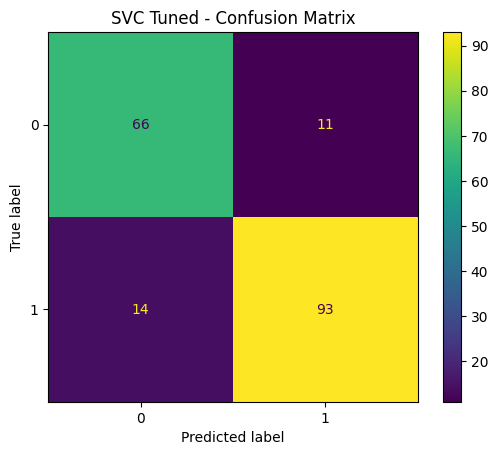

In [115]:
ConfusionMatrixDisplay.from_estimator(svc_rcv, x_test, y_test)
plt.title("SVC Tuned - Confusion Matrix")
plt.grid(False)
plt.show()

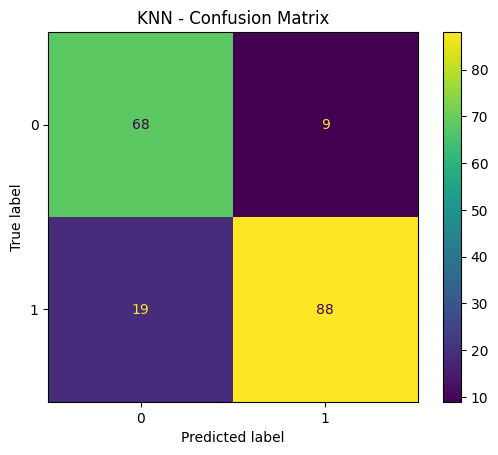

In [116]:
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test)
plt.title("KNN - Confusion Matrix")
plt.grid(False)
plt.show()

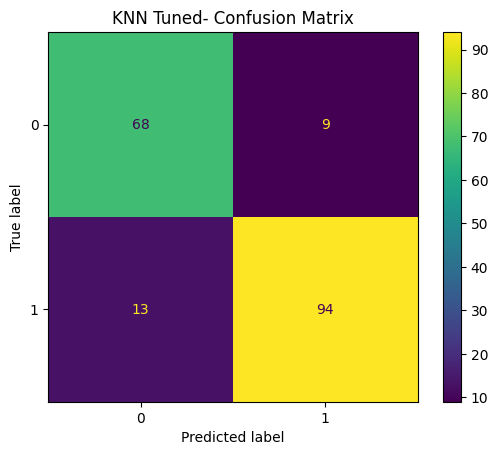

In [117]:
ConfusionMatrixDisplay.from_estimator(knn_rcv, x_test, y_test)
plt.title("KNN Tuned- Confusion Matrix")
plt.grid(False)
plt.show()

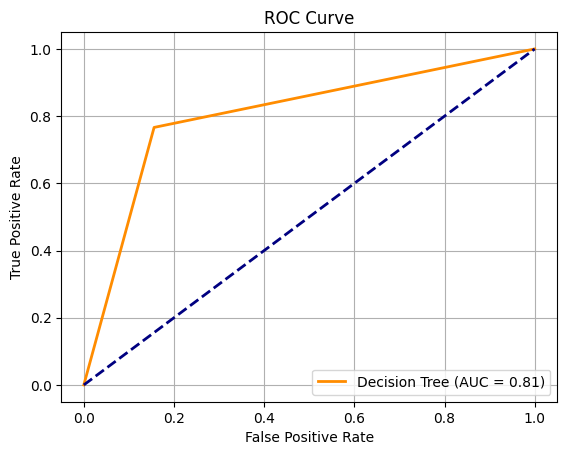

In [131]:
y_probs = dtree.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

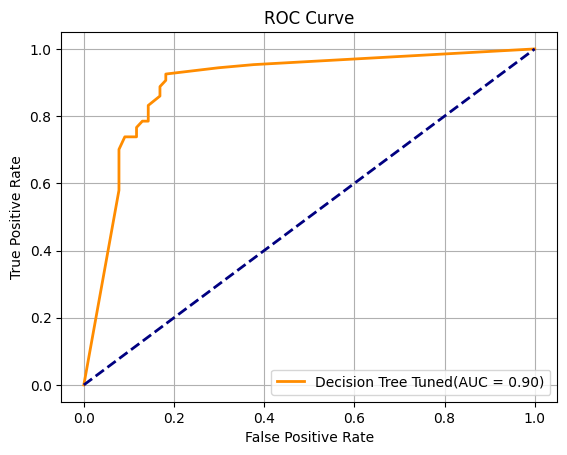

In [133]:
y_probs = dtree_rcv.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Decision Tree Tuned(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

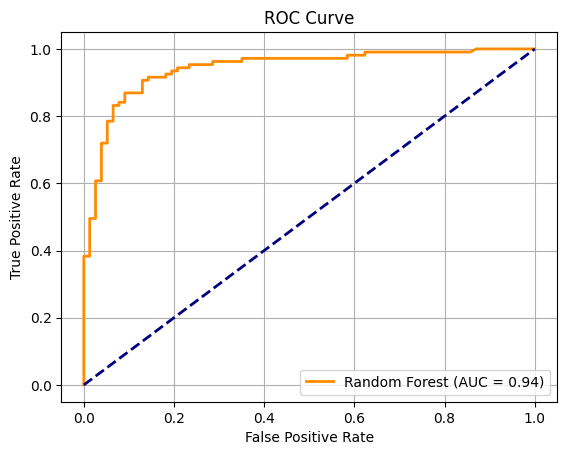

In [119]:
y_probs = rf.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

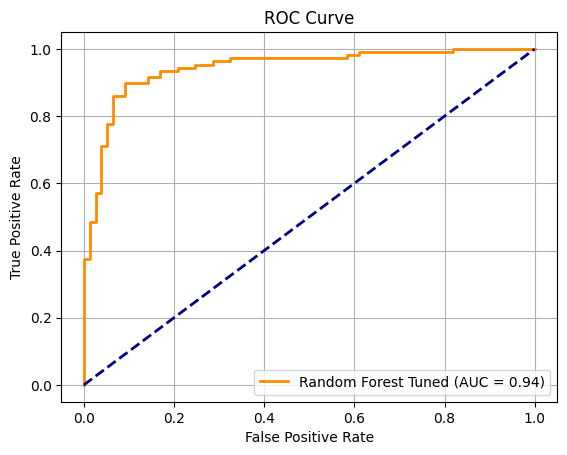

In [121]:
y_probs = rf_rcv.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest Tuned (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

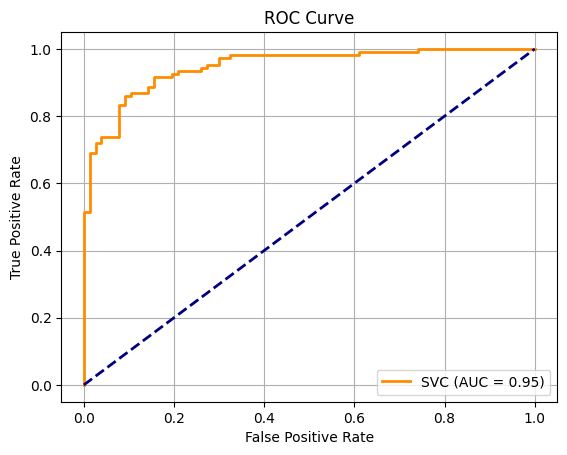

In [122]:
y_probs = svc.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

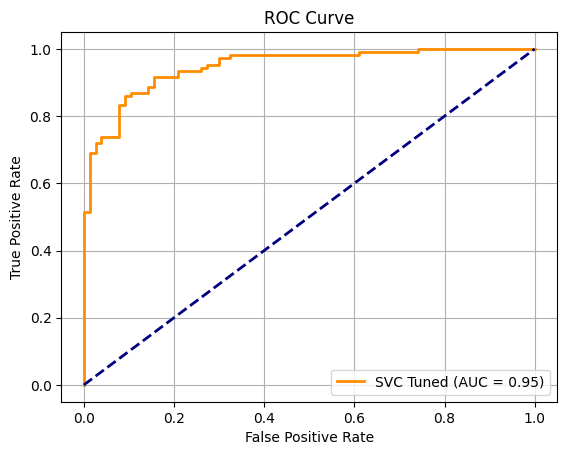

In [123]:
y_probs = svc_rcv.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVC Tuned (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

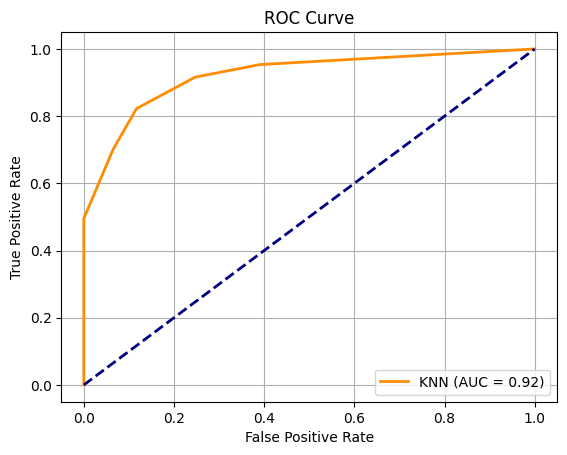

In [124]:
y_probs = knn.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

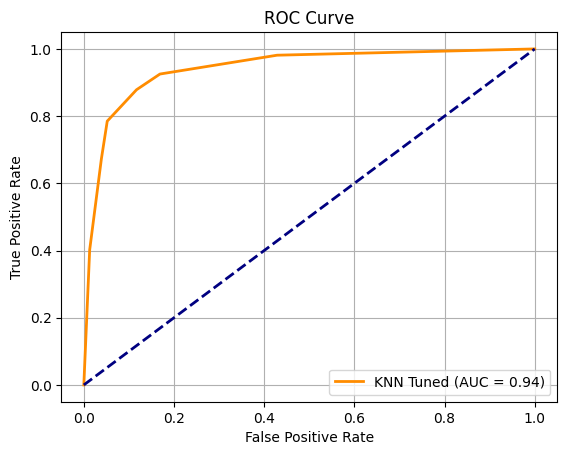

In [125]:
y_probs = knn_rcv.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'KNN Tuned (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

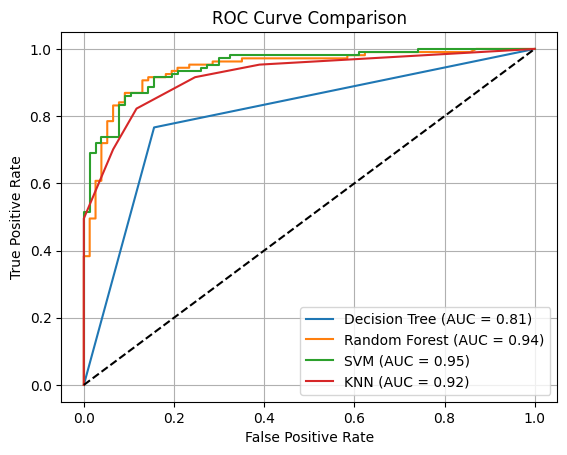

In [127]:
models = {
    'Decision Tree': dtree,
    'Random Forest': rf,
    'SVM': svc,
    'KNN': knn
}

for label, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

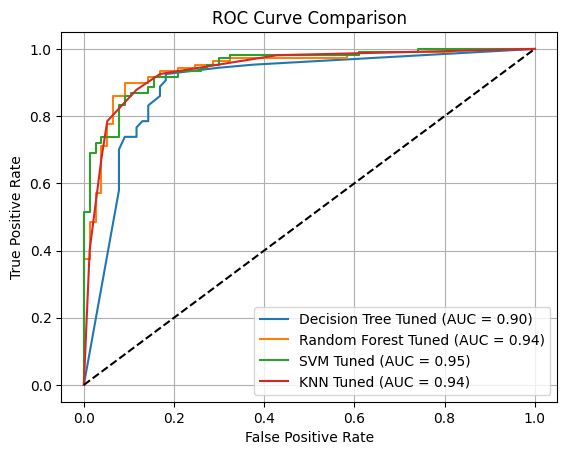

In [128]:
models = {
    'Decision Tree Tuned': dtree_rcv,
    'Random Forest Tuned': rf_rcv,
    'SVM Tuned': svc_rcv,
    'KNN Tuned': knn_rcv
}

for label, model in models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(x_test)[:, 1]
    else:
        probs = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Final Comparison and Conclusion

We evaluated 4 models:
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)

### Summary:

| Models (Tuned)       | ROC AUC | Comments |
|--------------------------------|---------|----------|
| Decision Tree             | 0.90    | Simple, interpretable, but prone to overfitting |
| Random Forest             | 0.94    | Best performance after tuning |
| SVM                      | 0.95    | Improved with feature scaling |
| KNN                     | 0.94    | Sensitive to distance & scaling |

### Observations:
- **SVM with tuning** achieved the best AUC scores.
- **Decision Tree and Random Forest** improved significantly with tuning
- **SVM and KNN** benefited from feature scaling.
- **Hyperparameter tuning** improved both accuracy and stability.
- **Confusion matrices and ROC** curves gave insight into per-class performance.
